In [1]:
import sys
sys.path.append('../')
from util import fill_window
from Attacked_Model.autoencoder_BATADAL import load_AEED
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_score, recall_score
import pickle
from sklearn.preprocessing import MinMaxScaler
import numpy as np
dataset = 'WADI'
data_folder = '../Data/'+dataset
att_data = pd.read_csv(data_folder+'/attack_1_from_test_dataset.csv')
xset = [col for col in att_data.columns if col not in [
        'Row', 'DATETIME','ATT_FLAG', '2_MV_001_STATUS', '2_LT_001_PV', '2_MV_002_STATUS']]

yset = ['ATT_FLAG']
autoencoder = load_AEED("../Attacked_Model/"+dataset+"/autoencoder.json", "../Attacked_Model/"+dataset+"/autoencoder.h5")
scaler = pickle.load(open("../Attacked_Model/"+dataset+"/scaler.p", "rb"))
with open("../Attacked_Model/"+dataset+"/theta") as f:
        theta = float(f.read())
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


../Attacked_Model/WADI/autoencoder.h5


/home/alessando/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/alessando/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.19.1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [2]:
def compute_scores(Y, Yhat):
    Y = Y.drop(Y.index[0:60])
    Yhat = Yhat.drop(Yhat.index[0:60])
    return [accuracy_score(Y, Yhat), f1_score(Y, Yhat), precision_score(Y, Yhat), recall_score(Y, Yhat)]#, fpr[0]]

# Evaluate Constrained attack over X dimension

In [3]:
results_mean_replay = {new_list: 0 for new_list in [2,3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,82]}
results_mean_white = {new_list: 0 for new_list in [2,3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,82]}
results_mean_black = {new_list: 0 for new_list in [2,3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,82]}
sum_orig = 0

original_data = pd.read_csv('../Data/'+dataset+'/attacks_october_clean_with_label.csv', parse_dates = ['DATETIME'], dayfirst=True)
original_data = original_data.set_index('DATETIME')

for i in [1,2,3,5,6,7,8,9,10,11,12,13,14,15]:
    df_test_01 = pd.read_csv('../Data/'+dataset+'/attack_'+str(i)+'_from_test_dataset.csv', parse_dates = ['DATETIME'], dayfirst=True)
    df_test_01 = fill_window(original_data, df_test_01, i, 60)
    X3 = pd.DataFrame(index=df_test_01.index, columns=xset,
                      data=scaler.transform(df_test_01[xset])) 
    Y3 = df_test_01[yset]
    Yhat3, _, _, _ = autoencoder.detect(X3, theta=theta, window=60, average=True)
    results_orig = pd.DataFrame(
                           columns=['accuracy', 'f1_score', 'precision', 'recall'])#,'fpr'])
    results_orig.loc['orig'] = compute_scores(Y3, Yhat3)
    sum_orig = sum_orig + results_orig.loc['orig'].at['accuracy']
    results_replay = {}
    results_white = {}
    results_black = {}
    for max_concealeble_variables in [2,3,4,5,6,7,8,9,10,15,20,30,40,50,60,70,80,82]:
            replay = pd.read_csv('../Adversarial_Attacks/Replay_Attack/results/'+dataset+'/attack_'+str(i)+
                                        '_replay_max_'+str(max_concealeble_variables)+'.csv', dayfirst=True)
            if not(max_concealeble_variables == 82):
                white_box = pd.read_csv('../Adversarial_Attacks/Whitebox_Attack/results/'+dataset+'/max_constraints_fixed/whitebox_attack_'+str(i)+
                                        '_from_test_dataset_max_'+str(max_concealeble_variables)+'.csv', dayfirst=True)
                black_box = pd.read_csv('../Adversarial_Attacks/Black_Box_Attack/results/'+dataset+'/AE_max_concealable_var_'+
                                        str(max_concealeble_variables)+
                                        '/new_advAE_attack_'+str(i)+'_from_test_dataset_max'+str(max_concealeble_variables)+'.csv', dayfirst=True)
            else:
                white_box = pd.read_csv('../Adversarial_Attacks/Whitebox_Attack/results/'+dataset+'/unconstrained_attack/new_improved_whitebox_attack_'+str(i)+'_from_test_dataset.csv', dayfirst=True)
                black_box = pd.read_csv('../Adversarial_Attacks/Black_Box_Attack/results/'+dataset+'/unconstrained_attack/new_advAE_attack_'+str(i)+'_from_test_dataset.csv', dayfirst=True)
                          
            
            replay = fill_window(original_data, replay, i, 60)
            white_box = fill_window(original_data, white_box, i, 60)
            black_box = fill_window(original_data, black_box, i, 60)
            replay = pd.DataFrame(index=replay.index, columns=xset,
                      data=scaler.transform(replay[xset]))
            white_box = pd.DataFrame(index=white_box.index, columns=xset,
                      data=scaler.transform(white_box[xset]))
            black_box = pd.DataFrame(index=black_box.index, columns=xset,
                      data=scaler.transform(black_box[xset]))

            Y4 = Y3#[1]*len(replay)
            Y5 = Y3#[1]*len(white_box)
            Y6 = Y3#[1]*len(black_box)
            
            Yhat4, _, _, _ = autoencoder.detect(replay, theta=theta, window=60, average=True)
            Yhat5, _, _, _ = autoencoder.detect(white_box, theta=theta, window=60, average=True)
            Yhat6, _, _, _ = autoencoder.detect(black_box, theta=theta, window=60, average=True)
            
            results = pd.DataFrame(
                           columns=['accuracy', 'f1_score', 'precision', 'recall'])#,'fpr'])
            #results.loc['original'] = compute_scores(Y3, Yhat3)
            results.loc['replay'] = compute_scores(Y4, Yhat4)
            results.loc['white'] = compute_scores(Y5, Yhat5)
            results.loc['black'] = compute_scores(Y6, Yhat6)
            
            
            #print(i, max_concealeble_variables)
            #print(results)
            
            results_replay[max_concealeble_variables] = results.loc['replay'].at['recall']
            results_white[max_concealeble_variables] = results.loc['white'].at['recall']
            results_black[max_concealeble_variables] = results.loc['black'].at['recall']  
            
            results_mean_replay[max_concealeble_variables] = results_mean_replay[max_concealeble_variables] + results_replay[max_concealeble_variables]
            results_mean_white[max_concealeble_variables] = results_mean_white[max_concealeble_variables] + results_white[max_concealeble_variables]
            results_mean_black[max_concealeble_variables] = results_mean_black[max_concealeble_variables] + results_black[max_concealeble_variables]

In [4]:
results_attack = pd.DataFrame(columns=[82,80,70,60,50,40,30,20,15,10,9,8,7,6,5,4,3,2])
for j in [82,80,70,60,50,40,30,20,15,10,9,8,7,6,5,4,3,2]:
    results_attack.loc['replay', j] = round(results_mean_replay[j]/14, 2)
    results_attack.loc['white', j] = round(results_mean_white[j]/14, 2)
    results_attack.loc['black', j] = round(results_mean_black[j]/14, 2)

In [5]:
print("Original Recall: "+str(round(sum_orig/14,2)))
print("Recall After Constrained Variables Adversarial Attack")
results_attack

Original Recall: 0.68
Recall After Constrained Variables Adversarial Attack


,82,80,70,60,50,40,30,20,15,10,9,8,7,6,5,4,3,2
replay,0.07,0.15,0.55,0.7,0.74,0.79,0.89,0.87,0.85,0.65,0.64,0.62,0.62,0.62,0.6,0.44,0.4,0.49
white,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.07,0.08,0.09,0.12,0.12,0.12,0.12,0.12,0.14,0.25
black,0.31,0.31,0.31,0.4,0.4,0.4,0.45,0.41,0.41,0.32,0.36,0.36,0.36,0.34,0.27,0.27,0.27,0.29


<Figure size 432x288 with 0 Axes>

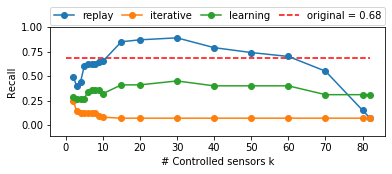

In [6]:
import matplotlib.pyplot as plt
legend = ['replay', 'iterative', 'learning']
plt.tight_layout()
fig, ax = plt.subplots(figsize=(6,2))
ax.hlines(y=round(sum_orig/14,2),xmin=0, xmax=82, color='r', linestyles='--',)
ax.plot(results_attack.transpose(), 'o-')
plt.xticks(np.arange(0, 82, 10))
plt.ylim(-0.11,1.0)
plt.legend(np.append(legend, 'original = '+str(round(sum_orig/14,2))),bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.)
#plt.title('Recall score after constrained attack')
plt.xlabel('# Controlled sensors k')
plt.ylabel('Recall')
plt.savefig('plot_recall_WADI.pdf', bbox_inches = "tight")
plt.show()

In [7]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y
A = [70, results_attack[70]['black']]
B = [80, results_attack[80]['black']]
C = [70, results_attack[70]['replay']]
D = [80, results_attack[80]['replay']]
#print(line_intersection((A,B), (C, D)))
x, _ = line_intersection((A,B), (C, D))
print(round(x/82, 2))

0.93


In [8]:
results_attack.to_latex()

'\\begin{tabular}{lllllllllllllllllll}\n\\toprule\n{} &    82 &    80 &    70 &    60 &    50 &    40 &    30 &    20 &    15 &    10 &    9  &    8  &    7  &    6  &    5  &    4  &    3  &    2  \\\\\n\\midrule\nreplay &  0.07 &  0.15 &  0.55 &   0.7 &  0.74 &  0.79 &  0.89 &  0.87 &  0.85 &  0.65 &  0.64 &  0.62 &  0.62 &  0.62 &   0.6 &  0.44 &   0.4 &  0.49 \\\\\nwhite  &  0.07 &  0.07 &  0.07 &  0.07 &  0.07 &  0.07 &  0.07 &  0.07 &  0.07 &  0.08 &  0.09 &  0.12 &  0.12 &  0.12 &  0.12 &  0.12 &  0.14 &  0.25 \\\\\nblack  &  0.31 &  0.31 &  0.31 &   0.4 &   0.4 &   0.4 &  0.45 &  0.41 &  0.41 &  0.32 &  0.36 &  0.36 &  0.36 &  0.34 &  0.27 &  0.27 &  0.27 &  0.29 \\\\\n\\bottomrule\n\\end{tabular}\n'

# Evaluate Constrained Attack over D dimension

In [9]:
results_mean_percentage_reduced = {new_list: [] for new_list in [5, 10, 25, 50, 75]}#['5%', '10%', '25%', '50%', '75%']}
results_percentage_reduced = {}
accuracy = {}
for percentage in [5, 10, 25, 50, 75]:
    accuracy[percentage] = {}
    for seed in [0, 1, 12, 123, 1234, 12345, 123456, 1234567, 12345678, 123456789]:
        for i in [1,2,3,5,6,7,8,9,10,11,12,13,14,15]:

            dataset = pd.read_csv('../Adversarial_Attacks/Black_Box_Attack/results/WADI/AE_'+str(percentage)
                                    +'_percent/seed_'+str(seed)+'/new_advAE_attack_'+str(i)+'_from_test_dataset.csv'
                                    , dayfirst=True)
            dataset = fill_window(original_data, dataset, i, 60)
            
            dataset = pd.DataFrame(index=dataset.index, columns=xset,
                      data=scaler.transform(dataset[xset]))
            Y7  = pd.DataFrame([1]*len(dataset))
            Yhat7, _, _, _ = autoencoder.detect(dataset, theta=theta, window=3, average=True)
            
            results = pd.DataFrame(
                           columns=['accuracy', 'f1_score', 'precision', 'recall'])
            results.loc['percentage'] = compute_scores(Y7, Yhat7) 
            
            try:
                  accuracy[percentage]['att_'+str(i)].append(results.loc['percentage'].at['accuracy'])                              
            except:
                accuracy[percentage]['att_'+str(i)] = []
                accuracy[percentage]['att_'+str(i)].append(results.loc['percentage'].at['accuracy'])
    mean=[]
    std = []
    for i in [1,2,3,5,6,7,8,9,10,11,12,13,14,15]:
        mean.append(np.mean(accuracy[percentage]['att_'+str(i)]))
        std.append(np.std(accuracy[percentage]['att_'+str(i)]))
    
    results_mean_percentage_reduced[percentage].append(np.mean(mean))
    results_mean_percentage_reduced[percentage].append(np.mean(std))

results_mean_percentage_reduced=pd.DataFrame.from_dict(results_mean_percentage_reduced, orient='index', columns = ['mean', 'std'])

In [10]:
print("Accuracy after Constrained Attack over D Dimension")
results_mean_percentage_reduced.round(2)

Accuracy after Constrained Attack over D Dimension


,mean,std
5,0.24,0.06
10,0.24,0.04
25,0.24,0.03
50,0.26,0.01
75,0.27,0.06
